In [1]:
import numpy as np
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy.ma as ma
import seaborn as sns
import scipy.optimize
from matplotlib import cm
from numpy import unravel_index
from scipy.stats import ks_2samp

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

### Load necessary tracking and RCE data

In [2]:
# array of years
years = np.arange( 1983, 2008 )

# create list of file names
#file_years = file_concatenator_ERAI(years)
file_years = file_concatenator_ERA5(years)

# Are we only looking at tropical MCSs?
minlat_array = nc_open_compile(file_years,"min latitude")
maxlat_array = nc_open_compile(file_years,"max latitude")
pmax_array = nc_open_compile(file_years,"pmax")

tropical_indx = np.argwhere( (minlat_array >= -10) & (maxlat_array <= 10) & (pmax_array >= 10**(-1)))[:,0]

In [3]:
rad_array = nc_open_compile(file_years,"rad")
rad_ERA = negative_to_nan(rad_array)[tropical_indx]
pmax_array = nc_open_compile(file_years,"pmax")
pmax_ERA = negative_to_nan(pmax_array)[tropical_indx]

In [4]:
path = '/groups/sylvia/JAS-MCS-rain/RCE-postprocessed/'
ssts = np.arange( 290, 316, 5 )
means, p99s, rad = read_RCE_files( path )
pmean_RCE = RCE_concat( means, 'p_rate' )
rad_RCE = np.concatenate( [r for r in rad], axis=0 )

### Plot precipitation intensity filtered by MCS extent

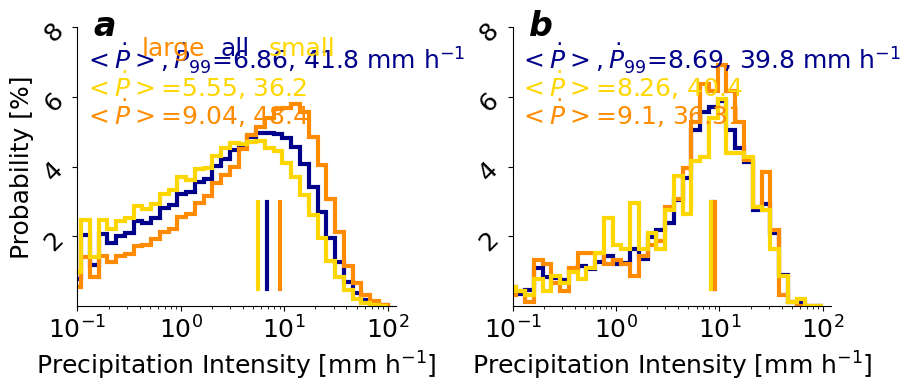

In [19]:
fig, ax = plt.subplots( nrows=1, ncols=2, figsize=(9,3.8), constrained_layout=True )
lw = 3
fs = 18
nbin = 60

wgts = np.ones_like(pmax_ERA)/float(len(pmax_ERA))*100.
ax[0].hist( pmax_ERA, bins=np.logspace(-3,2,nbin), weights=wgts, histtype=u'step', lw=lw, color='darkblue' )
ax[0].plot( [np.nanmean(pmax_ERA), np.nanmean(pmax_ERA)], [0.5,3], lw=lw, color='darkblue' )
upp = np.percentile( rad_ERA, 75 )
wgts = np.ones_like(pmax_ERA[rad_ERA >= upp])/float(len(pmax_ERA[rad_ERA >= upp]))*100.
ax[0].hist( pmax_ERA[rad_ERA >= upp], bins=np.logspace(-3,2,nbin), weights=wgts, histtype='step', lw=lw, color='darkorange' )
ax[0].plot( [np.nanmean(pmax_ERA[rad_ERA >= upp]), np.nanmean(pmax_ERA[rad_ERA >= upp])], [0.5,3], lw=lw, color='darkorange' )
loo = np.percentile( rad_ERA, 25 )
wgts = np.ones_like(pmax_ERA[rad_ERA <= loo])/float(len(pmax_ERA[rad_ERA <= loo]))*100.
ax[0].hist( pmax_ERA[rad_ERA <= loo], bins=np.logspace(-3,2,nbin), weights=wgts, histtype='step', lw=lw, color='gold' )
ax[0].plot( [np.nanmean(pmax_ERA[rad_ERA <= loo]), np.nanmean(pmax_ERA[rad_ERA <= loo])], [0.5,3], lw=lw, color='gold' )
ax[0].set_ylabel( 'Probability [%]', fontsize=fs )
#ax[0].text( 0.02, 0.85, r"$<\dot{P}>, \dot{P}_{99}$=" + f"{np.nanmean(pmax_ERA):.3}" + ', ' +
#           f"{np.nanpercentile(pmax_ERA,99):.3}" + r' mm h$^{-1}$', color='darkblue', fontsize=fs, transform=ax[0].transAxes)
#ax[0].text( 0.02, 0.75, r"$<\dot{P}>$=" + f"{np.nanmean(pmax_ERA[rad_ERA<=loo]):.3}" + ', ' +
#           f"{np.nanpercentile(pmax_ERA[rad_ERA<=loo],99):.3}" , color='gold', fontsize=fs, transform=ax[0].transAxes)
#ax[0].text( 0.02, 0.65, r"$<\dot{P}>$=" + f"{np.nanmean(pmax_ERA[rad_ERA>=upp]):.3}" + ', ' +
#           f"{np.nanpercentile(pmax_ERA[rad_ERA>=upp],99):.3}", color='darkorange', fontsize=fs, transform=ax[0].transAxes)
ax[0].set_xlim([10**(-3.5),1])
ax[0].text( 0.05, 0.97, 'a', weight='bold', style='italic', fontsize=fs+6, transform=ax[0].transAxes )
ax[0].text( 0.2, 0.9, 'large', color='darkorange', fontsize=fs, transform=ax[0].transAxes )
ax[0].text( 0.45, 0.9, 'all', color='darkblue', fontsize=fs, transform=ax[0].transAxes )
ax[0].text( 0.6, 0.9, 'small', color='gold', fontsize=fs, transform=ax[0].transAxes )

wgts = np.ones_like(pmean_RCE)/float(len(pmean_RCE))*100.
ax[1].hist( pmean_RCE, bins=np.logspace(-3,2,nbin), weights=wgts, lw=lw, color='darkblue', histtype=u'step' )
ax[1].plot( [np.nanmean(pmean_RCE), np.nanmean(pmean_RCE)], [0.5,3], lw=lw, color='darkblue' )
upp = np.percentile( rad_RCE, 75 )
wgts = np.ones_like(pmean_RCE[rad_RCE >= upp])/float(len(pmean_RCE[rad_RCE >= upp]))*100.
ax[1].hist( pmean_RCE[rad_RCE >= upp], bins=np.logspace(-3,2,nbin), lw=lw, color='darkorange', weights=wgts, histtype='step' )
ax[1].plot( [np.nanmean(pmean_RCE[rad_RCE >= upp]), np.nanmean(pmean_RCE[rad_RCE >= upp])], [0.5,3], lw=lw, color='darkorange' )
loo = np.percentile( rad_RCE, 25 )
wgts = np.ones_like(pmean_RCE[rad_RCE <= loo])/float(len(pmean_RCE[rad_RCE <= loo]))*100.
ax[1].hist( pmean_RCE[rad_RCE <= loo], bins=np.logspace(-3,2,nbin), weights=wgts, histtype='step', lw=lw, color='gold' )
ax[1].text( 0.05, 0.97, 'b', weight='bold', style='italic', fontsize=fs+6, transform=ax[1].transAxes )
ax[1].plot( [np.nanmean(pmean_RCE[rad_RCE <= loo]), np.nanmean(pmean_RCE[rad_RCE <= loo])], [0.5,3], lw=lw, color='gold' )
#ax[1].text( 0.02, 0.85, r"$<\dot{P}>, \dot{P}_{99}$=" + f"{np.nanmean(pmean_RCE):.3}" + ", " +
#           f"{np.nanpercentile(pmean_RCE,99):.4}" + r' mm h$^{-1}$', color='darkblue', fontsize=fs, transform=ax[1].transAxes)
#ax[1].text( 0.02, 0.75, r"$<\dot{P}>$=" + f"{np.nanmean(pmean_RCE[rad_RCE<=loo]):.3}" + ", "
#           f"{np.nanpercentile(pmean_RCE[rad_RCE<=loo],99):.4}", color='gold', fontsize=fs, transform=ax[1].transAxes)
#ax[1].text( 0.02, 0.65, r"$<\dot{P}>$=" + f"{np.nanmean(pmean_RCE[rad_RCE>=upp]):.3}" + ", "
#           f"{np.nanpercentile(pmean_RCE[rad_RCE>=upp],99):.4}", color='darkorange', fontsize=fs, transform=ax[1].transAxes)
ax[1].set_xscale( 'log' )

for a in ax:
    a.set_xlim([0.1,120])
    a.set_xlabel( r'Precipitation Intensity [mm h$^{-1}$]', fontsize=fs )
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.tick_params( 'both', labelsize=18 )
    a.tick_params( 'y', rotation=45 )
    a.set_xscale( 'log' )
    a.set_ylim([0,8])
    a.set_yticks( [2, 4, 6, 8] )
    
#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/precip-intensity-clustering_p99s.pdf', bbox_inches='tight' )
plt.show()

### Histogram of saturation deficit for all, small, and large MCSs in RCE output

1.5494441
1.5106008
1.6838832


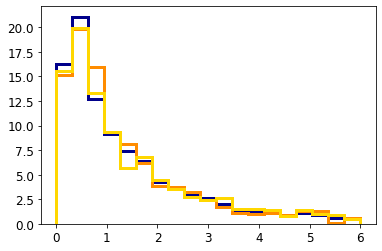

In [6]:
sd_RCE = RCE_concat( p99s, 'SD' )
nbin = 20
sdupper = 6
fig = plt.figure()
wgts = np.ones_like(sd_RCE)/float(len(sd_RCE))*100.
upp = np.percentile( rad_RCE, 75 )
loo = np.percentile( rad_RCE, 25 )
plt.hist( sd_RCE, bins=np.linspace(0,sdupper,nbin), weights=wgts, histtype=u'step', lw=lw, color='darkblue' )
print(np.nanmean(sd_RCE))

wgts = np.ones_like(sd_RCE[rad_RCE >= upp])/float(len(sd_RCE[rad_RCE >= upp]))*100.
plt.hist( sd_RCE[rad_RCE >= upp], bins=np.linspace(0,sdupper,nbin), weights=wgts, histtype=u'step', lw=lw, color='darkorange' )
print(np.nanmean(sd_RCE[rad_RCE >= upp]))

wgts = np.ones_like(sd_RCE[rad_RCE <= loo])/float(len(sd_RCE[rad_RCE <= loo]))*100.
plt.hist( sd_RCE[rad_RCE <= loo], bins=np.linspace(0,sdupper,nbin), weights=wgts, histtype=u'step', lw=lw, color='gold' )
print(np.nanmean(sd_RCE[rad_RCE <= loo]))

### Histogram of specific humidity for all, small, and large MCSs in RCE output

In [1]:
qv_RCE = RCE_concat( p99s, 'QV' )
qv_RCE_sum = np.nansum( qv_RCE, axis=1 )

nbin = 20
sdupper = 6
fig = plt.figure()
wgts = np.ones_like(qv_RCE_sum)/float(len(qv_RCE_sum))*100.
upp = np.percentile( rad_RCE, 75 )
loo = np.percentile( rad_RCE, 25 )
plt.hist( qv_RCE_sum, weights=wgts, bins=np.linspace(50,600,nbin), histtype=u'step', lw=lw, color='darkblue' )
print(np.nanmean(qv_RCE))

wgts = np.ones_like(qv_RCE_sum[rad_RCE >= upp])/float(len(qv_RCE_sum[rad_RCE >= upp]))*100.
plt.hist( qv_RCE_sum[rad_RCE >= upp], bins=np.linspace(50,600,nbin), weights=wgts, histtype=u'step', lw=lw, color='darkorange' )
print(np.nanmean(qv_RCE_sum[rad_RCE >= upp]))

wgts = np.ones_like(qv_RCE_sum[rad_RCE <= loo])/float(len(qv_RCE_sum[rad_RCE <= loo]))*100.
plt.hist( qv_RCE_sum[rad_RCE <= loo], bins=np.linspace(50,600,nbin), weights=wgts, histtype=u'step', lw=lw, color='gold' )
print(np.nanmean(qv_RCE_sum[rad_RCE <= loo]))

NameError: name 'RCE_concat' is not defined

### Histogram of omega for all, small, and large MCSs in RCE output

18.699505
15.80242
20.725695


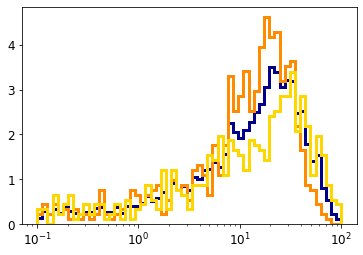

In [13]:
omega_RCE = RCE_concat( p99s, 'omega' )
omega_RCE = omega_RCE[:,17]
omega_RCE = xr.where( omega_RCE < 0, -1.*omega_RCE, np.nan )
bins = np.logspace( -1, 2, 60 )

nbin = 20
fig = plt.figure()
wgts = np.ones_like(omega_RCE)/float(len(omega_RCE))*100.
upp = np.percentile( rad_RCE, 75 )
loo = np.percentile( rad_RCE, 25 )
plt.hist( omega_RCE, weights=wgts, bins=bins, histtype=u'step', lw=lw, color='darkblue' )
print(np.nanmean(omega_RCE))

wgts = np.ones_like(omega_RCE[rad_RCE >= upp])/float(len(omega_RCE[rad_RCE >= upp]))*100.
plt.hist( omega_RCE[rad_RCE >= upp], weights=wgts, bins=bins, histtype=u'step', lw=lw, color='darkorange' )
print(np.nanmean(omega_RCE[rad_RCE >= upp]))

wgts = np.ones_like(omega_RCE[rad_RCE <= loo])/float(len(omega_RCE[rad_RCE <= loo]))*100.
plt.hist( omega_RCE[rad_RCE <= loo], weights=wgts, bins=bins, histtype=u'step', lw=lw, color='gold' )
print(np.nanmean(omega_RCE[rad_RCE <= loo]))

plt.gca().set_xscale( 'log' )